## Introduction ##

Hey there for everyone!

My name is Vasyukhin Artem and Im glad to see you in my GH repository of "Supervised learning" project!

Today we gonna look at client database of "Beta-bank" for check the reason why people leaving. By the side of view of product manager catch a new clients is more expensive than save the initial.

Our target - build ML model which can predict will client leave bank or no.

**Features**

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Target**
* Exited — факт ухода клиента



## Library and data import ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [2]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## EDA ##

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# deleting useless for ML-model columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
# rename columns to correct look
data = data.rename(columns={
    'CreditScore': 'credit_score', 
    'Geography': 'geography', 
    'Gender': 'gender', 
    'Age': 'age', 
    'Tenure': 'tenure', 
    'Balance': 'balance', 
    'NumOfProducts': 'personal_products',
    'HasCrCard': 'has_cr_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited'})

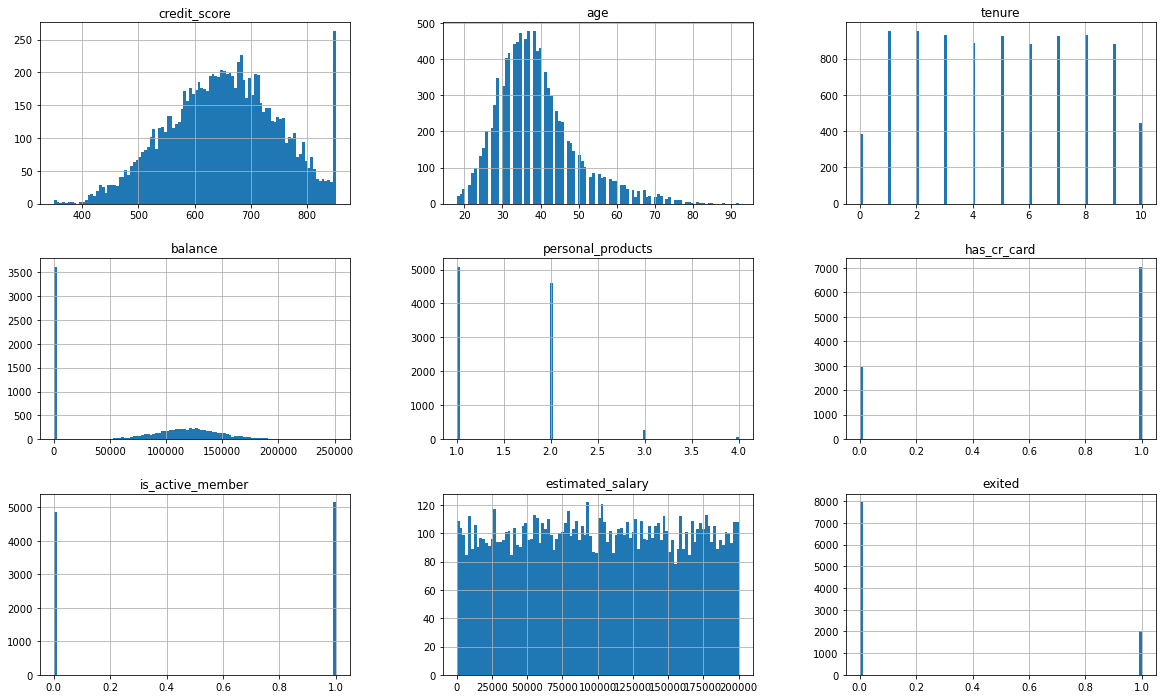

In [7]:
data.hist(figsize=(20, 12), bins=100);

<div class = "alert alert-info" style="border-left: 7px solid blue">

As we can see, into columns **CreditScore** and **Balance** we have emissions: in *CreditScore* max value emission, in *Balance* emission stack at the null. Also we have uneven distribution of credit cards.

The major idea of our feature work - its uneven distribution in our target column **Exited**. Thats why we will use ***f-score*** for to assess the quality of the constructed model.

### Dublicates ###

Because in our data not a lot of unique information, we will check our data only for explicit duplicates. Other data we will accept as correct.

In [8]:
data[data.duplicated()]

,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited


### Pass processing ##

Where we check data information, passes was only in **Tenure** column. Lets look at data and try to find some patterns.

In [9]:
data[data['tenure'].isna()]

,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


For the next steps we creating variable **data_fixed**. If we will need original dataset we will back to it with original variable **data**

Also we will encode **geography** and **gender** columns.

In [10]:
data_fixed = data

print(data_fixed.shape)
data_fixed.head()

(10000, 11)


,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Lets check **credit_score** column, because we can see emissions near 400 value and take a look at rows with max rate and passes into **tenure** column.

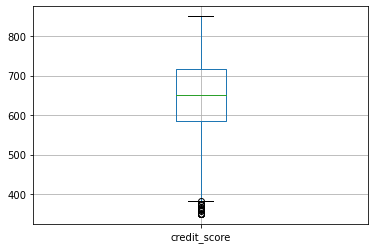

In [11]:
data.boxplot(['credit_score']);

In [12]:
# lets filter our 'credit_score' column under 1 quantile
data_fixed[data_fixed['credit_score'] < 390]

,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
942,376,France,Female,46,NaN,0.00,1,1,0,157333.69,1
1193,363,Spain,Female,28,6.0,146098.43,3,1,0,100615.14,1
1405,359,France,Female,44,NaN,128747.69,1,1,0,146955.71,1
1631,350,Spain,Male,54,1.0,152677.48,1,1,1,191973.49,1
1838,350,Germany,Male,39,0.0,109733.20,2,0,0,123602.11,1
1962,358,Spain,Female,52,8.0,143542.36,3,1,0,141959.11,1
2473,351,Germany,Female,57,4.0,163146.46,1,1,0,169621.69,1
2579,365,Germany,Male,30,0.0,127760.07,1,1,0,81537.85,1
5285,386,Spain,Female,53,1.0,131955.07,1,1,1,62514.65,1


In [13]:
data_fixed[(data_fixed['credit_score'] >= 850) & (data_fixed['tenure'].isna())]

,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
180,850,Spain,Female,45,NaN,122311.21,1,1,1,19482.50,0
559,850,Spain,Female,70,NaN,0.00,1,1,1,705.18,0
1059,850,France,Male,38,NaN,80293.98,1,0,0,126555.74,0
1483,850,France,Male,36,NaN,104077.19,2,0,1,68594.00,0
2329,850,France,Male,35,NaN,162442.35,1,1,0,183566.78,0
2416,850,France,Male,46,NaN,117640.39,1,1,0,88920.68,0
2619,850,Spain,Male,49,NaN,0.00,1,0,0,25867.67,1
2834,850,France,Male,30,NaN,121535.18,1,0,0,40313.47,0
3822,850,France,Female,39,NaN,104386.53,1,1,0,105886.77,0
4141,850,Spain,Male,39,NaN,141829.67,1,1,1,92748.16,0


In [14]:
print(data_fixed['tenure'].value_counts())

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64


In [15]:
# fill passes random numbers between 0 and 10

data_fixed['tenure'] = data_fixed['tenure'].fillna(np.random.randint(10))
data_fixed['tenure'].isna().sum()

0

In [16]:
# check the result
data_fixed['tenure'].value_counts()

6.0     1790
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
10.0     446
0.0      382
Name: tenure, dtype: int64

In [17]:
# lets look at first 10 rows in "data_fixed"

data_fixed.head(10)

,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Lets encode **geography** by class with *replace* method. At this time we will use *replace*, because One-Heat Encoding we will use to encode **gender** column.

In [18]:
# replacing countries by 0, 1, 2
data_fixed['geography'] = data_fixed['geography'].replace(['Germany', 'Spain', 'France'], ['0', '1', '2'])

# encode "gender" column with "dummy" method and resist dummy-trap by drop 1st column
data_fixed['gender'] = pd.get_dummies(data['gender'], drop_first=True)

# checking info of data and printing first 15 rows
data_fixed.info()
display(data_fixed.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   geography          10000 non-null  object 
 2   gender             10000 non-null  uint8  
 3   age                10000 non-null  int64  
 4   tenure             10000 non-null  float64
 5   balance            10000 non-null  float64
 6   personal_products  10000 non-null  int64  
 7   has_cr_card        10000 non-null  int64  
 8   is_active_member   10000 non-null  int64  
 9   estimated_salary   10000 non-null  float64
 10  exited             10000 non-null  int64  
dtypes: float64(3), int64(6), object(1), uint8(1)
memory usage: 791.1+ KB


,credit_score,geography,gender,age,tenure,balance,personal_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,2,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,1,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,2,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,2,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,1,0,43,2.0,125510.82,1,1,1,79084.10,0
5,645,1,1,44,8.0,113755.78,2,1,0,149756.71,1
6,822,2,1,50,7.0,0.00,2,1,1,10062.80,0
7,376,0,0,29,4.0,115046.74,4,1,0,119346.88,1
8,501,2,1,44,4.0,142051.07,2,0,1,74940.50,0
9,684,2,1,27,2.0,134603.88,1,1,1,71725.73,0


<div class = "alert alert-info" style="border-left: 7px solid blue">

### Total of EDA ###

After EDA, we got correct dataset without string values. Now our data is ready for construct ML-model

## Preparing data for ML ##

In [19]:
# creating of train, test and valid features and target
features = data_fixed.drop('exited', axis=1)
target = data_fixed['exited']

features_train, features_rem, target_train, target_rem = train_test_split(
    features, target, test_size=0.35, random_state=69)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_rem, target_rem, test_size=0.35, random_state=69)

# check the result
pd.DataFrame({
    'Type': ['default', 'train', 'test', 'valid'],
    'Features split size': [features.shape, features_train.shape, features_test.shape, features_valid.shape],
    'Target split size': [target.shape, target_train.shape, target_test.shape, target_valid.shape]})

,Type,Features split size,Target split size
0,default,"(10000, 10)","(10000,)"
1,train,"(6500, 10)","(6500,)"
2,test,"(2275, 10)","(2275,)"
3,valid,"(1225, 10)","(1225,)"


Now we construct standard scaler for calculating of Logistic Regression model, because our target is uneven distribution.

In [20]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test) 
features_valid_scaled = scaler.transform(features_valid) 

### Decision Tree ###

In [21]:
%%time

# variables for best results of hyperparameters
best_score_tree = 0
best_depth_tree = 0

# loop for find best depth
for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=69)
    model_tree.fit(features_train, target_train)
    
    predicted_tree = model_tree.predict(features_valid)
    tree_score = accuracy_score(target_valid, predicted_tree)
    
    if tree_score > best_score_tree:
        best_score_tree = tree_score
        best_depth_tree = depth

print('Best accuracy for DT:', best_score_tree)
print('Best depth for DT:', best_depth_tree)
print('')

Best accuracy for DT: 0.8514285714285714
Best depth for DT: 5

CPU times: total: 359 ms
Wall time: 369 ms


### Random Forest ###

In [22]:
%%time

# same as for decision tree
# start loop by 20 trees
best_score_forest = 0
best_depth_forest = 0

for depth in range(1, 30, 1):
    model_forest = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=69)
    model_forest.fit(features_train, target_train)
        
    predicted_forest = model_forest.predict(features_valid)
    forest_score = accuracy_score(target_valid, predicted_forest)
        
    if forest_score > best_score_forest:
        best_score_forest = forest_score
        best_depth_forest = depth
            
print('Best accuracy for RF:', best_score_forest)
print('Best depth for RF:', best_depth_forest)
print('')

Best accuracy for RF: 0.8555102040816327
Best depth for RF: 21

CPU times: total: 2.8 s
Wall time: 2.86 s


In [23]:
%%time

best_score_forest = 0
best_est_forest = 0
best_depth_forest = 0

# loop for find best estimators and depth
for est in range(1, 60, 1):
    for depth in range(1, 20, 1):
        model_forest = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=69)
        model_forest.fit(features_train, target_train)
        
        predicted_forest = model_forest.predict(features_test)
        forest_score = accuracy_score(target_test, predicted_forest)
        
        if forest_score > best_score_forest:
            best_score_forest = forest_score
            best_est_forest = est
            best_depth_forest = depth
            
print('Best accuracy:', best_score_forest)
print('Best estimators:', best_est_forest)
print('Best depth:', best_depth_forest)
print('')

Best accuracy: 0.8712087912087912
Best estimators: 37
Best depth: 9

CPU times: total: 2min 27s
Wall time: 2min 29s


In [24]:
# соберем полученную информацию в наглядную таблицу
pd.DataFrame({
    'Classification': ['Decision Tree', 'Random Forest'],
    'Best accuracy': [best_score_tree, best_score_forest],
    'Best depth': [best_depth_tree, best_depth_forest],
    'Best estimators': ['-', best_est_forest]
})

,Classification,Best accuracy,Best depth,Best estimators
0,Decision Tree,0.851429,5,-
1,Random Forest,0.871209,9,37


<div class = "alert alert-info" style="border-left: 7px solid blue">

### Total of preparing model ###
After construct models and check them their accuracy, we got best result from "Random Forest" method with hyperparameters **n_estimators=57** и **max_depth=10**.

## F-score for disbalanced sample ##

### Decision Tree ###

In [25]:
# constructing model with previous best hyperparameters
model_tree = DecisionTreeClassifier(max_depth=best_depth_tree, random_state=69)
model_tree.fit(features_train, target_train)
    
predicted_tree = model_tree.predict(features_test)

# calculating accuracy, precision, recall and f-score
tree_score = accuracy_score(target_test, predicted_tree)
precision_tree = precision_score(target_test, predicted_tree)
recall_tree = recall_score(target_test, predicted_tree)
f_score_tree = f1_score(target_test, predicted_tree)

### Random Forest ###

In [26]:
#same as for decision tree, but for random forest

model_forest = RandomForestClassifier(n_estimators=best_est_forest, max_depth=best_depth_forest, random_state=69)
model_forest.fit(features_train, target_train)
        
predicted_forest = model_forest.predict(features_test)

forest_score = accuracy_score(target_test, predicted_forest)
precision_forest = precision_score(target_test, predicted_forest)
recall_forest = recall_score(target_test, predicted_forest)
f_score_forest = f1_score(target_test, predicted_forest)

In [27]:
# create a table to show the results

f_score_disbalanced = pd.DataFrame({
    'Metric': ['Decision Tree', 'Random Forest'],
    'acc_score': [tree_score, forest_score],
    'precision_score': [precision_tree, precision_forest], 
    'recall_score': [recall_tree, recall_forest], 
    'f_score': [f_score_tree, f_score_forest]
})

f_score_disbalanced

,Metric,acc_score,precision_score,recall_score,f_score
0,Decision Tree,0.859341,0.711765,0.521552,0.601990
1,Random Forest,0.871209,0.802120,0.489224,0.607764


<div class = "alert alert-info">

### Total for disbalanced models ###

Random Forest got the best f-score of other two models - 0.59. Next we will use this model with best hyperparameters for compare with balanced model.

## F-score for balanced sample ##

### Decision Tree ###

Below we doing same steps for cunstructing models as in previous cells, but now we balancing classes with special method for each model.

In [28]:
%%time


best_score_tree = 0
best_depth_tree = 0

for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=69, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    
    predicted_tree = model_tree.predict(features_valid)
    tree_score = accuracy_score(target_valid, predicted_tree)
    
    if tree_score > best_score_tree:
        best_score_tree = tree_score
        best_depth_tree = depth

print('Best accuracy DT:', best_score_tree)
print('Best depth DT:', best_depth_tree)
print('')

Best accuracy DT: 0.7853061224489796
Best depth DT: 7

CPU times: total: 375 ms
Wall time: 376 ms


In [29]:
model_tree_total = DecisionTreeClassifier(max_depth=best_depth_tree, random_state=69, class_weight='balanced')
model_tree_total.fit(features_train, target_train)

predicted_tree_valid = model_tree_total.predict(features_valid)

# calculate f-score
score_tree = model_tree_total.score(features_valid, target_valid)
precision_tree = precision_score(target_valid, predicted_tree_valid)
recall_tree = recall_score(target_valid, predicted_tree_valid)
f_score_tree = f1_score(target_valid, predicted_tree_valid)

print('Доля положительных предсказаний:', score_tree)
print('Доля правильных положительных предсказаний:', precision_tree)
print('Объем правильных положительных предсказаний:', recall_tree)
print('Среднее гармоническое:', f_score_tree)

Доля положительных предсказаний: 0.7853061224489796
Доля правильных положительных предсказаний: 0.5
Объем правильных положительных предсказаний: 0.7262357414448669
Среднее гармоническое: 0.592248062015504


### Random Forest ###

In [30]:
%%time

best_score_forest = 0
best_est_forest = 0
best_depth_forest = 0

# пройдемся циклом по числу деревьев в лесу и количеству ветвей для каждого из них 
# для поиска наилучшей доли правильных ответов, числа деревьев и количеству ветвей
for est in range(1, 70, 1):
    for depth in range(1, 25, 1):
        model_forest = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=69, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        
        predicted_forest = model_forest.predict(features_valid)
        forest_score = accuracy_score(target_valid, predicted_forest)
        
        if forest_score > best_score_forest:
            best_score_forest = forest_score
            best_est_forest = est
            best_depth_forest = depth
            
print('Accuracy RF:', best_score_forest)
print('Best estimators RF:', best_est_forest)
print('Best depth RF:', best_depth_forest)
print('')

Accuracy RF: 0.8604081632653061
Best estimators RF: 45
Best depth RF: 12

CPU times: total: 4min 21s
Wall time: 4min 24s


In [31]:
# construct random forest model with best hyperparameters
model_forest_total = RandomForestClassifier(
    n_estimators=best_est_forest, max_depth=best_depth_forest, random_state=69, class_weight='balanced')
model_forest_total.fit(features_train, target_train)

predicted_forest_valid = model_forest_total.predict(features_valid)

# calculate f-score
score_forest = model_forest_total.score(features_valid, target_valid)
precision_forest = precision_score(target_valid, predicted_forest_valid)
recall_forest = recall_score(target_valid, predicted_forest_valid)
f_score_forest = f1_score(target_valid, predicted_forest_valid)

print('Accuracy RF:', score_forest)
print('Precision RF:', precision_forest)
print('Recall RF:', recall_forest)
print('F-score RF:', f_score_forest)

Accuracy RF: 0.8604081632653061
Precision RF: 0.7149532710280374
Recall RF: 0.5817490494296578
F-score RF: 0.6415094339622641


In [32]:
# total results

f_score_balanced = pd.DataFrame({
    'Metrics': ['Decision Tree', 'Random Forest'],
    'acc_score': [score_tree, score_forest],
    'precision_score': [precision_tree, precision_forest],
    'recall_score': [recall_tree, recall_forest],
    'f_score': [f_score_tree, f_score_forest]
})


display(f_score_balanced)

,Metrics,acc_score,precision_score,recall_score,f_score
0,Decision Tree,0.785306,0.500000,0.726236,0.592248
1,Random Forest,0.860408,0.714953,0.581749,0.641509


<div class = "alert alert-info" style="border-left: 7px solid blue">

### Total for balanced models ###

After constructing models with balanced classes, **Random Forest** has show best result - ~0.66 f-score. This result is muuch higher than our previous f-score in Random Forest model, which was builded on the disbalanced samples.
    
Also we can see, what Logistic Regression have bad results even after we scaled our features samples and balanced classes. Major reason - disbalance of classes in geniune data.

## Auc-Roc ##

Below we construct two models - best from disbalance and best from balanced samples.

## Threshold change ##

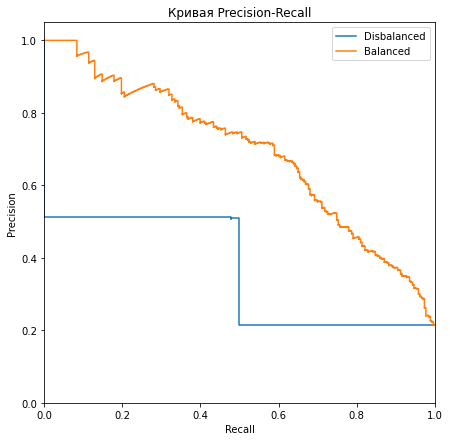

In [33]:
# threshold change for disbalanced random forest and separate list of precision, recall и threshold values
proba_valid_disbalanced = model_tree.predict_proba(features_valid)
precision_disbalanced, recall_disbalanced, thresholds_disbalanced = precision_recall_curve(
    target_valid, proba_valid_disbalanced[:, 1])

# same for abalanced
proba_valid_balanced = model_forest_total.predict_proba(features_valid)
precision_balanced, recall_balanced, thresholds_balanced = precision_recall_curve(target_valid, proba_valid_balanced[:, 1])

# build PR-arc
plt.figure(figsize=(7, 7))
plt.step(recall_disbalanced, precision_disbalanced, where='post')
plt.step(recall_balanced, precision_balanced, where='post')

# parameters for graphic and returning result
plt.legend(['Disbalanced', 'Balanced'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Construct ROC-arc and fing AUC for disbalanced and balanced models

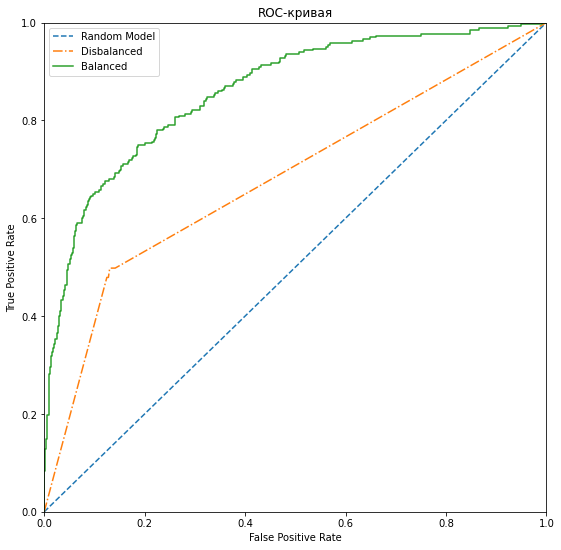

0.6812348323755167
0.8600270349319779


In [34]:
# threshold change for disbalanced and balanced models
proba_valid_disbalanced = model_tree.predict_proba(features_valid)
proba_one_valid_disbalanced = proba_valid_disbalanced[:, 1]

# changing threshold for balanced model
proba_valid_balanced = model_forest_total.predict_proba(features_valid)
proba_one_valid_balanced = proba_valid_balanced[:, 1]

# fpr, tpr and thresholds parameters for ROC-curve
fpr_disbalanced, tpr_disbalanced, thresholds_disbalanced = roc_curve(target_valid, proba_one_valid_disbalanced)
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid_balanced)

# graphic parameters
plt.figure(figsize=(9,9))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_disbalanced, tpr_disbalanced, linestyle='-.')
plt.plot(fpr, tpr, linestyle='-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(['Random Model', 'Disbalanced', 'Balanced'])
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# найдем площадь под кривыми моделей
print(roc_auc_score(target_valid, proba_one_valid_disbalanced))
print(roc_auc_score(target_valid, proba_one_valid_balanced))

<div class = "alert alert-info" style="border-left: 7px solid blue">

### Total of ROC-AUC ###

As we can see, balanced model have overwhelming superiority above disbalanced - 0.85 > 0.7.

Below we will check model results for upscaled and downscaled samples.

## Upscaling ##

In [35]:
# creating func of upscaling
def upscaled(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=69)
    
    return features_upsampled, target_upsampled

# using func to train samples
features_upscaled, target_upscaled = upscaled(features_train, target_train, 25)

# check the result
print(features_upscaled.shape)
print(target_upscaled.shape)

(37940, 10)
(37940,)


### Decision Tree ###

In [36]:
# variables for best results
best_score_tree_upscaled = 0
best_depth_tree_upscaled = 0

# same loop as previous
for depth in range(1, 20, 1):
    model_tree_upscaled = DecisionTreeClassifier(max_depth=depth, random_state=69)
    model_tree_upscaled = model_tree_upscaled.fit(features_upscaled, target_upscaled)
    
    tree_upscaled_predicted = model_tree_upscaled.predict(features_valid)
    score_tree_upscaled = model_tree_upscaled.score(features_valid, target_valid)
    
    if score_tree_upscaled > best_score_tree_upscaled:
        best_score_tree_upscaled = score_tree_upscaled
        best_depth_tree_upscaled = depth

print('Accuracy DT:', best_score_tree_upscaled)
print('Depth DT:', best_depth_tree_upscaled)
print('')

Accuracy DT: 0.7689795918367347
Depth DT: 18



In [37]:
model_tree_upscaled = DecisionTreeClassifier(max_depth=best_score_tree_upscaled, random_state=69)
model_tree_upscaled = model_tree_upscaled.fit(features_upscaled, target_upscaled)
    
tree_upscaled_predicted = model_tree_upscaled.predict(features_valid)


# calculate accuracy, precision, recall and f-score
score_tree_upscaled = model_tree_upscaled.score(features_valid, target_valid)
precision_tree_upscaled = precision_score(target_valid, tree_upscaled_predicted)
recall_tree_upscaled = recall_score(target_valid, tree_upscaled_predicted)
f_score_tree_upscaled = f1_score(target_valid, tree_upscaled_predicted)


print('Accuracy DT:', score_tree_upscaled)
print('Precision DT:', precision_tree_upscaled)
print('Recall DT:', recall_tree_upscaled)
print('F-score DT:', f_score_tree_upscaled)

Accuracy DT: 0.2146938775510204
Precision DT: 0.2146938775510204
Recall DT: 1.0
F-score DT: 0.353494623655914


### Random Forest ###

In [ ]:
%%time

# dooing same steps as in previous cells
best_score_forest_upscaled = 0
best_est_forest_upscaled = 0
best_depth_forest_upscaled = 0

for est in range(1, 30, 1):
    for depth in range(1, 25, 1):
        model_forest_upscaled = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=69)
        model_forest_upscaled.fit(features_upscaled, target_upscaled)
        
        predicted_forest_upscaled = model_forest_upscaled.predict(features_valid)
        forest_score_upscaled = accuracy_score(target_valid, predicted_forest_upscaled)
        
        if forest_score_upscaled > best_score_forest_upscaled:
            best_score_forest_upscaled = forest_score_upscaled
            best_est_forest_upscaled = est
            best_depth_forest_upscaled = depth
            
print('Accuracy RF:', best_score_forest_upscaled)
print('Best estimators:', best_est_forest_upscaled)
print('Best depth:', best_depth_forest_upscaled)
print('')

In [ ]:
model_forest_upscaled = RandomForestClassifier(
    n_estimators=best_est_forest_upscaled, max_depth=best_depth_forest_upscaled, random_state=69)
model_forest_upscaled = model_forest_upscaled.fit(features_upscaled, target_upscaled)

forest_upscaled_predicted = model_forest_upscaled.predict(features_valid)

# calculate accuracy, precision, recall and f-score
score_forest_upscaled = model_forest_upscaled.score(features_valid, target_valid)
precision_forest_upscaled = precision_score(target_valid, forest_upscaled_predicted)
recall_forest_upscaled = recall_score(target_valid, forest_upscaled_predicted)
f_score_forest_upscaled = f1_score(target_valid, forest_upscaled_predicted)


print('Score RF:', score_forest_upscaled)
print('Precision RF:', precision_forest_upscaled)
print('Recall RF:', recall_forest_upscaled)
print('F-score RF:', f_score_forest_upscaled)

In [ ]:
f_score_upscaled = pd.DataFrame({
    'Metrics': ['Decision Tree', 'Random Forest'],
    'acc_score': [score_tree_upscaled, score_forest_upscaled],
    'precision_score': [precision_tree_upscaled, precision_forest_upscaled],
    'recall_score': [recall_tree_upscaled, recall_forest_upscaled],
    'f_score': [f_score_tree_upscaled, f_score_forest_upscaled]
})

f_score_upscaled


As previously, **Random Forest** get best result with 0.65 f-score.

## Downscale sample ##

In [ ]:
# creating func for downscale samples
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=69)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=69)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=69)
    
    return features_downsampled, target_downsampled

# apply func to train samples
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

# check the result
print(features_downsampled.shape)
print(target_downsampled.shape)

### Decision Tree ###

In [ ]:
best_score_tree_downsampled = 0
best_depth_tree_downsampled = 0

for depth in range(1, 20, 1):
    model_tree_downsampled = DecisionTreeClassifier(max_depth=depth, random_state=69)
    model_tree_downsampled = model_tree_downsampled.fit(features_downsampled, target_downsampled)
    
    tree_downsampled_predicted = model_tree_downsampled.predict(features_valid)
    score_tree_downsampled = model_tree_downsampled.score(features_valid, target_valid)
    
    if score_tree_downsampled > best_score_tree_downsampled:
        best_score_tree_downsampled = score_tree_downsampled
        best_depth_tree_downsampled = depth

print('Score DT:', best_score_tree_downsampled)
print('Depth DT:', best_depth_tree_downsampled)
print('')

In [ ]:
model_tree_downsampled = DecisionTreeClassifier(max_depth=best_depth_tree_downsampled, random_state=69)
model_tree_downsampled = model_tree_downsampled.fit(features_downsampled, target_downsampled)

tree_downsampled_predicted = model_tree_upscaled.predict(features_valid)

# calculate accuracy, precision, recall and f-score
score_tree_downsampled = model_tree_downsampled.score(features_valid, target_valid)
precision_tree_downsampled = precision_score(target_valid, tree_downsampled_predicted)
recall_tree_downsampled = recall_score(target_valid, tree_downsampled_predicted)
f_score_tree_downsampled = f1_score(target_valid, tree_downsampled_predicted)

print('Accuracy DT:', score_tree_downsampled)
print('Precision DT:', precision_tree_downsampled)
print('Recall DT:', recall_tree_downsampled)
print('F-score DT:', f_score_tree_downsampled)

### Random Forest ###

In [ ]:
best_score_forest_downsampled = 0
best_est_forest_downsampled = 0
best_depth_forest_downsampled = 0

for est in range(1, 25, 1):
    for depth in range(1, 20, 1):
        model_forest_downsampled = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=69)
        model_forest_downsampled.fit(features_downsampled, target_downsampled)
        
        predicted_forest_downsampled = model_forest_downsampled.predict(features_valid)
        forest_score_downsampled = accuracy_score(target_valid, predicted_forest_downsampled)
        
        if forest_score_downsampled > best_score_forest_downsampled:
            best_score_forest_downsampled = forest_score_downsampled
            best_est_forest_downsampled = est
            best_depth_forest_downsampled = depth
            
print('Score RF:', best_score_forest_downsampled)
print('Best estimators RF:', best_est_forest_downsampled)
print('Best depth RF:', best_depth_forest_downsampled)
print('')

In [ ]:
model_forest_downsampled = RandomForestClassifier(
    n_estimators=best_est_forest_downsampled, max_depth=best_depth_forest_downsampled, random_state=69)
model_forest_downsampled = model_forest_downsampled.fit(features_downsampled, target_downsampled)

forest_downsampled_predicted = model_forest_downsampled.predict(features_valid)

# # calculate accuracy, precision, recall and f-score
score_forest_downsampled = model_forest_downsampled.score(features_valid, target_valid)
precision_forest_downsampled = precision_score(target_valid, forest_downsampled_predicted)
recall_forest_downsampled = recall_score(target_valid, forest_downsampled_predicted)
f_score_forest_downsampled = f1_score(target_valid, forest_downsampled_predicted)

print('Accuracy RF:', score_forest_downsampled)
print('Precision RF:', precision_forest_downsampled)
print('Recall RF:', recall_forest_downsampled)
print('F-score RF:', f_score_forest_downsampled)

In [ ]:
f_score_downsampled = pd.DataFrame({
    'Metrics': ['Decision Tree', 'Random Forest'],
    'acc_score': [score_tree_downsampled, score_forest_downsampled],
    'precision_score': [precision_tree_downsampled, precision_forest_downsampled],
    'recall_score': [recall_tree_downsampled, recall_forest_downsampled],
    'f_score': [f_score_tree_downsampled, f_score_forest_downsampled]
})

f_score_downsampled

## Best kind of disbalance compensation ##

In [ ]:
f_score_total = pd.DataFrame({
    'Kind of disbalance compensation': ['Threshold change', 'Upscaling', 'Downscaling'],
    'Best f-score': [f_score_forest, f_score_forest_upscaled, f_score_forest_downsampled]
})

f_score_total

<div class = "alert alert-info" style="border-left: 7px solid blue">

### Results of disbalance compensation ###

After testing three types of disbalance compensation, we can say what **random forest* model in **upscaled sample** is the best choice for our project.  Besides, we found out what upscaling in 10, 25 and 50 times best was in **25** and the results worsened as the sample got larger (in **10 times** - 0.65, **25** - 0.67, **40** - 0.64). This signals about bad scaling of model which overteaching or comfusing when analysis large samples.

Downscaling also was bad: due to insufficient number of signs model can't correct predict leaving of client. Thats why we will not use this method.

At all we can say, what the best kind of disbalance compensation is **threshold change** and **upscale sample** in 25 times.

## Testing the best model ##

Lets teach our model on upscaled sample with best hyperparameters.

In [ ]:
# construct total model of random forest
model_forest_total = RandomForestClassifier(
    n_estimators=best_est_forest, max_depth=best_depth_forest, random_state=69, class_weight='balanced')
model_forest_total.fit(features_upscaled, target_upscaled)

total_predicted = model_forest_total.predict(features_test)

# calculate accuracy, precision, recall and f-score
score_total = model_forest_total.score(features_test, target_test)
precision_total = precision_score(target_test, total_predicted)
recall_total = recall_score(target_test, total_predicted)
f_score_total = f1_score(target_test, total_predicted)

print('Score total:', score_total)
print('Precision total:', precision_total)
print('Recall total:', recall_total)
print('F-score total:', f_score_total)

In [ ]:
proba_valid_balanced = model_forest_total.predict_proba(features_valid)
precision_balanced, recall_balanced, thresholds_balanced = precision_recall_curve(target_valid, proba_valid_balanced[:, 1])

proba_test = model_forest_total.predict_proba(features_test)
precision_test, recall_test, thresholds_test = precision_recall_curve(target_test, proba_test[:, 1])

# counstruct PR-curve
plt.figure(figsize=(7, 7))
plt.step(recall_balanced, precision_balanced, where='post')
plt.step(recall_test, precision_test, where='post')

# set the graphic parameters and return it
plt.legend(['Balanced', 'Test'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

In [ ]:
# divide the predictions valid and best models
proba_one_valid_balanced = proba_valid_balanced[:, 1]

proba_one_test = proba_test[:, 1]

# set parameters of fpr, tpr and thresholds for ROC-curve
fpr, tpr, thresholds = roc_curve(target_valid, proba_one_valid_balanced)
fpr_test, tpr_test, thresholds_test = roc_curve(target_test, proba_one_test)

# set the graphic parameters
plt.figure(figsize=(9,9))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, linestyle='-')
plt.plot(fpr_test, tpr_test, linestyle='-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(['Random Model', 'Balanced', 'Test'])
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# printing results
print(roc_auc_score(target_valid, proba_one_valid_balanced))
print(roc_auc_score(target_test, proba_one_test))

## Total result ##

<div class = "alert alert-info" style="border-left: 7px solid blue">
    
In the course of work we:
- processed dataset, which applied to construct for construct ML-models;
- teached models on the balanced and unbalanced samples;
- proved what model, teached on balanced sample, have higher f-score than unbalanced;
- created graphic of ROC-curve and calculate AUC-score. Results prooves what balanced model of Random Forest is better tham unbalanced, although results of unbalanced was higher.
    
Thats why the balanced model of Random Forest is complitely good for predicting will clients leave or no.

# GitHub #

Below you can check my GH repository with this and other ML-projects.

- Project above with commits: https://github.com/Vasart-ds/git_project
- Main profile: https://github.com/Vasart-ds

**Thanks for watching! See you later!**